# Unlocking Flexibility with AiiDA-WorkTree

In this blog, I will introduce you to AiiDA-WorkTree, a framework for designing flexible node-based workflows using AiiDA. I will compare it with the already existing AiiDA workflow components and highlight the benefits of WorkTree.

AiiDA has two builtin workflow components: `workfunction` and `WorkChain`. The `workfunction` is simple but lacks automatic checkpointing, a crucial feature for long-running calculations. `WorkChain` supports automatic checkpointing, thus is recommended by the AiiDA community.

### Limitation of `WorkChain`
There are two big limitations of the `WorkChain`:

- demands a more complex implementation, thus need advanced Python user.
- lack flexbility for different use cases. Imagine planning a train journey. Using a WorkChain resembles creating a new train line for every unique journey. Traveling from Zurich to Milano? That's one line (e.g., ICE10). Heading from Milano to Rome? That's another (e.g., ICE11). Combining journeys, say from Zurich to Rome, would entail the creation of yet another train line (e.g., ICE12), despite the redundancy. However, a more optimized approach exists, where one could travel from Zurich to Milano on ICE10 and then switch to ICE11 from Milano to Rome.

AiiDA-WorkTree introduces a new component: `WorkTree`. It simplifies implementation and embraces automatic checkpointing, all while maintaining a high degree of flexibility suitable for designing workflows for different use cases.

Let's show this by an example. Suppose we want to calculate ```(x + y) * z ``` in two steps:

- add `x` and `y`.
- then multiply the result with `z`.


To run the examples, we first load the AiiDA profile.



In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

### An example workchain
First, create the `calcfunction` to do the calculation and generate new data. Then, create the `AddAndMultiplyWorkChain` class. User needs to define:

- inputs and outputs of the `spec`.
- outline
- the function to call the `calcfunction`: `add` and `multiply`


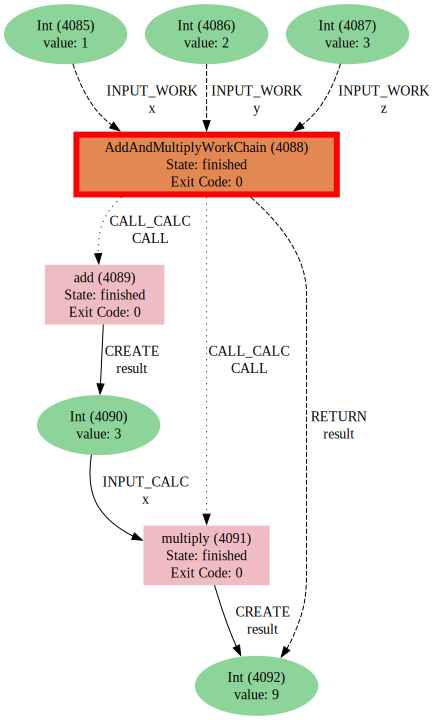

In [2]:
from aiida.engine import WorkChain, calcfunction, run_get_node
from aiida.orm import Int
from aiida_worktree.utils import generate_node_graph

@calcfunction
def add(x, y):
    return Int(x + y)

@calcfunction
def multiply(x, y):
    return Int(x * y)

class AddAndMultiplyWorkChain(WorkChain):

    @classmethod
    def define(cls, spec):
        super().define(spec)
        spec.input('x')
        spec.input('y')
        spec.input('z')
        spec.outline(
            cls.add,
            cls.multiply,
            cls.results,
        )
        spec.output('result')

    def add(self):
        self.ctx.sum = add(self.inputs.x, self.inputs.y)

    def multiply(self):
        self.ctx.product = multiply(self.ctx.sum, self.inputs.z)

    def results(self):
        self.out('result', self.ctx.product)


# Run the workchain
result, node = run_get_node(AddAndMultiplyWorkChain, x=Int(1), y=Int(2), z=Int(3))

generate_node_graph(node.pk)

Note that we use the `run` method instead of `submit`. To submit the WorkChain, one must ensure that the WorkChain is properly importable, meaning it is part of the `PYTHONPATH`.


### An example WorkTree
There are three steps to create a workflow using WorkTree.

- create an empty `WorkTree`
- add nodes: `add` and `multiply`. Note, AiiDA-WorkTree goes one step further by transforming a `calcfunction` to a `Node`.
- link the output of the `add` node to one of the `x` input of the `multiply` node.

WorkTree node created, PK: 4096


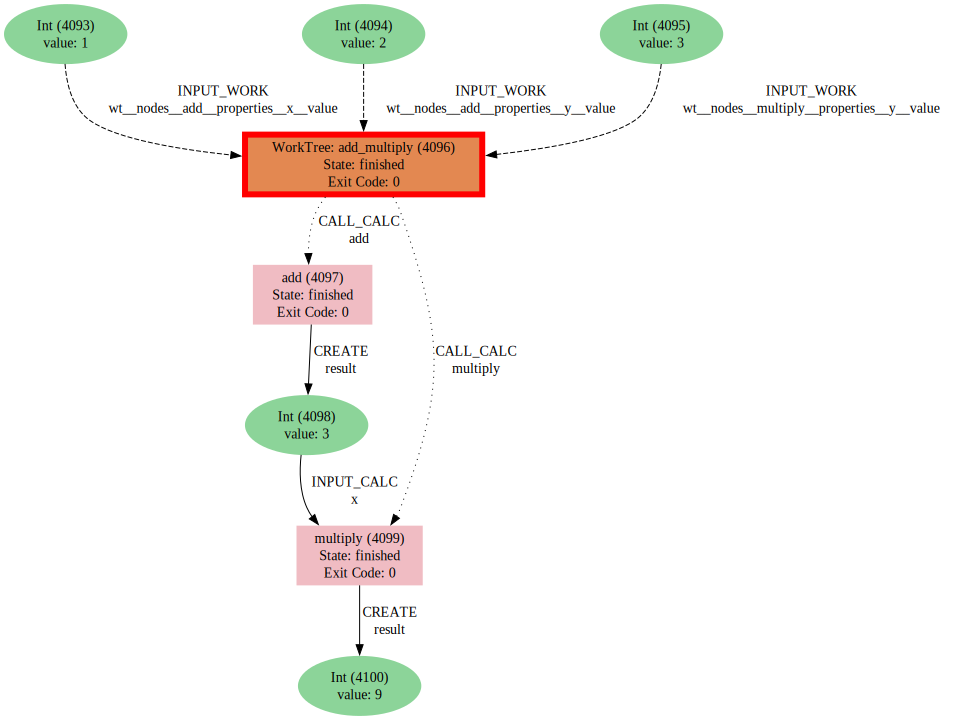

In [3]:
from aiida_worktree import node, WorkTree
from aiida.orm import Int

# define add node
@node.calcfunction()
def add(x, y):
    return x + y

# define multiply node
@node.calcfunction()
def multiply(x, y):
    return x*y

# create worktree
wt = WorkTree("add_multiply")
# add nodes to worktree
wt.nodes.new(add, name="add")
wt.nodes.new(multiply, name="multiply")
# link add and multiply nodes
wt.links.new(wt.nodes["add"].outputs[0], wt.nodes["multiply"].inputs["x"])

# Submit the worktree
wt.submit(inputs = {"add": {"x": Int(1),
                            "y": Int(2)},
                    "multiply": {"y": Int(3)}},
        wait=True)

generate_node_graph(wt.pk)

You will observe that both the WorkChain and WorkTree generate similar node graphs. However, it's worth noting that WorkTree requires less Python code and utilizes a simpler Python grammar. Additionally, the process of creating the workflow with WorkTree closely aligns with human logic, making it more intuitive and user-friendly.

### Extend the workflow
Now, suppose a user has another workflow: add the result of previous workflow ```(x + y) * z``` with `a`. 


1. **WorkChain**

One need to create another WorkChain, either from scratch, or use the `AddAndMultiplyWorkChain` and exposing its inputs. Here,we create a new WorkChain: `AddAndMultiplyAddWorkChain` from scratch.

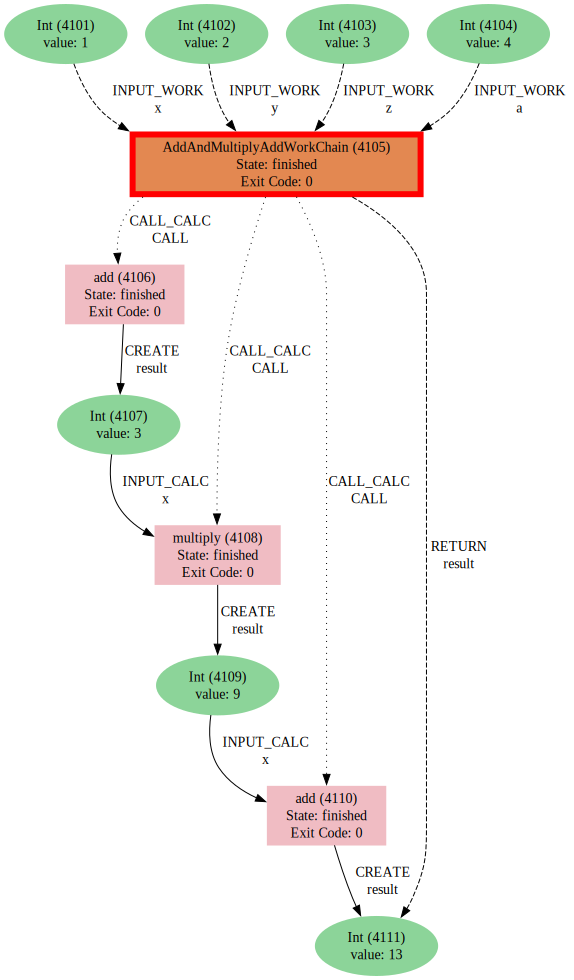

In [4]:
class AddAndMultiplyAddWorkChain(WorkChain):

    @classmethod
    def define(cls, spec):
        super().define(spec)
        spec.input('x')
        spec.input('y')
        spec.input('z')
        spec.input('a')
        spec.outline(
            cls.add,
            cls.multiply,
            cls.add2,
            cls.results,
        )
        spec.output('result')

    def add(self):
        self.ctx.sum = add(self.inputs.x, self.inputs.y)

    def multiply(self):
        self.ctx.product = multiply(self.ctx.sum, self.inputs.z)

    def add2(self):
        self.ctx.sum = add(self.ctx.product, self.inputs.a)

    def results(self):
        self.out('result', self.ctx.sum)

# Run the workchain
result, node = run_get_node(AddAndMultiplyAddWorkChain, x=Int(1), y=Int(2), z=Int(3), a=Int(4))

generate_node_graph(node.pk)

2. **WorkTree**

Add a new node to WorkTree is straightforward.

WorkTree node created, PK: 4116


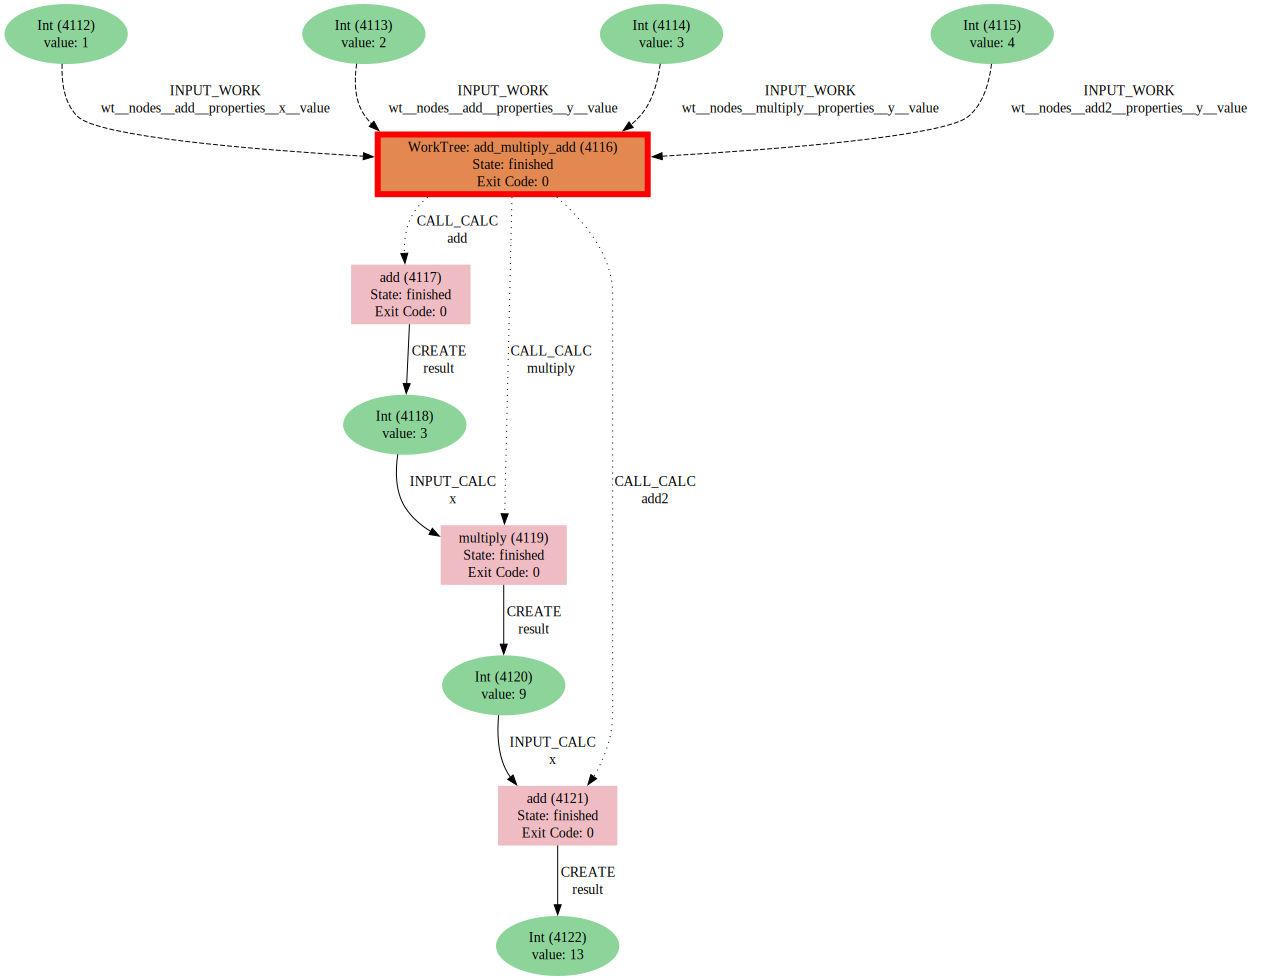

In [5]:
wt2 = WorkTree(name="add_multiply_add")
# add nodes to worktree
wt2.nodes.new(add, name="add")
wt2.nodes.new(multiply, name="multiply")
wt2.nodes.new(add, name="add2")
# link add and multiply nodes
wt2.links.new(wt2.nodes["add"].outputs[0], wt2.nodes["multiply"].inputs["x"])
wt2.links.new(wt2.nodes["multiply"].outputs[0], wt2.nodes["add2"].inputs["x"])

# Submit the worktree
wt2.submit(inputs = {"add": {"x": Int(1),
                            "y": Int(2)},
                    "multiply": {"y": Int(3)},
                    "add2": {"y": Int(4)}},
        wait=True)

generate_node_graph(wt2.pk)

## **Unpacking the Benefits of WorkTree**

In the scenario of AiiDA WorkChain, the overall process is broken down into distinct steps, where each step must be completed before the next one begins. Within each of these sequential steps, multiple tasks or jobs can be executed in parallel. It's typically referred to as Hybrid Sequential-Parallel Execution. 

In the case of WorkTree, which involves Dependency-based Execution or a Directed Acyclic Graph (DAG) approach, offers several advantages, especially in complex and multi-step workflows:

- Efficient Resource Utilization: By allowing tasks to run as soon as their dependencies are met, this approach can make better use of available resources. It minimizes idle time as tasks don't have to wait for an entire level or sequence to complete.

- Optimized Performance: It naturally enables higher levels of parallelism. Independent tasks can be processed simultaneously, leading to faster overall completion times.

- Flexibility and Scalability: The DAG model is highly flexible and scalable. It can accommodate changes in the workflow, such as adding new tasks or modifying dependencies, without major reconfiguration.

- Enhanced Error Handling and Debugging: By structuring workflows into smaller, dependent tasks, it's easier to pinpoint and address errors. If a task fails, only its dependent tasks are affected, not the entire workflow.

- Improved Workflow Management: It allows for more precise control over the workflow. Tasks can be dynamically scheduled (e.g., pause, play), leading to more efficient workflow management.

- Better Clarity and Visualization: DAGs provide a clear visual representation of task dependencies, making it easier to understand and communicate the workflow structure.

## **Choosing the Right Tool: WorkTree or WorkChain?**

WorkTree amplifies the **distinction between the AiiDA users and developers**. It allows developers to focus on creating foundational WorkChains, likened to establishing essential train routes. Users, on the other hand, can effortlessly utilize and connect these foundational elements to tailor workflows that cater to their specific needs, without delving deep into development.


### **When to use WorkTree?**

WorkTree is recommanded when 
- the workflow primarily involves linking outputs of one AiiDA process to the inputs of another.
- the workflow needs great flexibility

### **When is WorkChain the Preferable Choice?**

WorkChain should be your go-to option when 
- the workflow demands intricate flow controls, i.e., multiple while loops and conditional statements.
- the workflow is very common and do not need combine with other workflows.

### **Conclusion: The AiiDA-WorkTree Vision**

AiiDA-WorkTree does not seek to replace the existing workflow components like WorkChain, calcfunction, or calcjob. Instead, it envisions enriching the workflow ecosystem, enabling users to craft flexible, and user-specific workflows with ease. By doing so, AiiDA-WorkTree heralds a new era of workflow management, fostering creativity, efficiency in the AiiDA community.

## What's Next

|        |                                         |
|---------------|----------------------------------------------------|
| [Concepts](../concept/index.rst)                          | A brief introduction of WorkTree’s main concepts.  |
| [Tutorials](../tutorial/index.rst)                        | Real-world examples in computational materials science and more.                     |
| [HowTo](../howto/index.rst)                              | Advanced topics and tips, e.g flow control using `if`, `for`, `while` and `context`.    |